## Classification

Here we'll utilize the previous' notebook output and logic to be able to try and classify our data.

We'll begin with using some basic ML models (like Logistic Regression and tree-based models). So let's do just that.

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
base_data_dir = './data'

Reading the data that was saved to disk from the augmentation notebook.

In [3]:
latest_data_dir_num = max([int(dir.split('_')[-1]) for dir in os.listdir(base_data_dir) if dir.split('_')[-1].isdigit()])
data_dir = [dir for dir in os.listdir(base_data_dir) if dir.split('_')[-1].isdigit() and int(dir.split('_')[-1]) == latest_data_dir_num][0]
data_dir = f'{base_data_dir}/{data_dir}'

In [4]:
import h5py

In [5]:
with h5py.File(f'{data_dir}/final_images.h5') as f:
    images = f['final_images'][:].squeeze()

with h5py.File(f'{data_dir}/final_labels.h5') as f:
    labels = f['final_labels'][:]

In [6]:
images.shape

(30726, 176, 144)

In [7]:
from modules.models.utils import normalize_images

Since our first $10242$ images are normalized and properly visualized, we want to normalize the generated images.

In [8]:
# original shape of images from augmentation notebook is 10242
original_images_factor = images.shape[0] // 10242
generated_images_start_idx = images.shape[0] // original_images_factor

In [9]:
# images = images.astype(np.float32)
images[generated_images_start_idx:] = normalize_images(images[generated_images_start_idx:])
images = images.astype(np.uint8)

In [10]:
images.shape

(30726, 176, 144)

Now for the fun stuff. Let's create some basic models and try and classify each sample.

We'll do the same as we did with the tree-based models - we'll create an initial model using some educated guessed parameters, and according to the results we'll continue to hyperparameter tuning, if necessary.

First, let's create the dataframes using the logic from the eda process we did earlier. Since our dataset is renewed, our means, standard deviations (and possibly, column to be dropped) needs to be recalculated. 

Let's start with the training data, using the images we loaded from disk to calculate the relevant data.

In [11]:
random_state = 42

class_distributions = np.unique(labels, return_counts=True)[1]
class_weights = np.apply_along_axis(lambda x: labels.shape[0] / (np.unique(labels).shape[0] * x), arr=np.unique(labels, return_counts=True)[1], axis=0)
class_weights = {i: value for i, value in zip([0, 1, 2, 3], class_weights)}

In [12]:
from modules.models.utils import create_dataset, get_dataset_params

dataset_params = get_dataset_params()

In [ ]:
df, df_cols_to_drop, df_cols_means, df_cols_stds = create_dataset(images, labels, **dataset_params, is_train=True)

Now let's prepare the test dataset for the creation of the final dataset.

In [14]:
test_data_dir = './data/alzheimer/test'
classes = os.listdir(test_data_dir)
class_to_idx = {}
for i in range(len(classes)):
    class_to_idx[classes[i]] = i

total_test_images = 0
for class_name in classes:
    total_test_images += len(os.listdir(f'{test_data_dir}/{class_name}'))

In [15]:
test_images = np.empty((total_test_images, 208, 176), dtype=np.uint8)
test_labels = np.empty(total_test_images, dtype=np.uint8)

In [16]:
from tqdm.notebook import tqdm
from PIL import Image

In [17]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
image_idx = 0
for class_name in classes:
    for image_name in tqdm(os.listdir(f'{test_data_dir}/{class_name}')):
        image_path = f'{test_data_dir}/{class_name}/{image_name}'
        test_images[image_idx] = np.array(Image.open(image_path)).astype(np.uint8)
        test_labels[image_idx] = class_to_idx[class_name]
        image_idx += 1

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

In [19]:
test_df = create_dataset(test_images, test_labels, **dataset_params, means=df_cols_means, stds=df_cols_stds, drop_cols=df_cols_to_drop, boundary_pixels=(16, 191, 159, 16), is_train=False)

In [20]:
# using the labels variable instead
df.drop('class', axis=1, inplace=True)
test_df.drop('class', axis=1, inplace=True)

Now we begin with the initialization of the models. 

We'll start with Logistic Regression, see how it compares to the models we tried earlier and see if there's any improvement.

Since the data is not linearly separable, I'm not so optimistic about its performances, but let's keep an open mind.

Logistic Regression:

Defining the initial model:

In [21]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression(penalty=None, dual=False, class_weight=class_weights, random_state=random_state, n_jobs=-1)

In [22]:
logistic_regression.fit(df, labels)

LogisticRegression(class_weight={0: 1.7855648535564854, 1: 24.620192307692307,
                                 2: 0.50009765625, 3: 0.7144252232142857},
                   n_jobs=-1, penalty=None, random_state=42)

Training was fairly long. Probably due to the enlarged dataset. 

Total Accuracy: 0.5215011727912432

Precision: 
MildDemented: 0.37735849056603776
ModerateDemented: 0.5555555555555556
NonDemented: 0.6008902077151336
VeryMildDemented: 0.4609375

Recall: 
MildDemented: 0.44692737430167595
ModerateDemented: 0.4166666666666667
NonDemented: 0.6328125
VeryMildDemented: 0.3950892857142857

F1 Score: 
MildDemented: 0.4092071611253197
ModerateDemented: 0.47619047619047616
NonDemented: 0.6164383561643836
VeryMildDemented: 0.4254807692307692



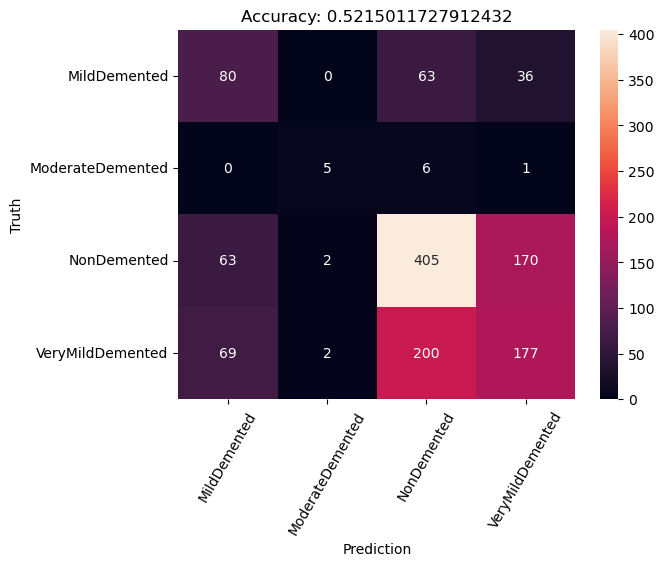

In [23]:
from modules.models.utils import show_metrics

test_preds = logistic_regression.predict(test_df)
show_metrics(test_labels, test_preds, classes=classes)

The results are not good, but not that bad either. The model was able to predict moderate and mild demented samples, where the mild demented ones he got a precision score of 0.53 which is very good in comparison to our other models. We can see a similar thing about the non demented and its' recall score, but since it is the majority class, we wouldn't expect anything less.

So basically, this looks promising. Let's try and tune it a bit and see if we can get a better result.



In [24]:
from modules.models.utils import initialize_custom_hyperparameters

def logistic_regression_custom_objective(trial):
    params = initialize_custom_hyperparameters(
        trial=trial,
        params={
            'penalty': ['categorical', ['l2', None]],
            'dual': ['categorical', [False]],
            'C': ['float', [0.01, 3]],
            'solver': ['categorical', ['lbfgs']],
            'multi_class': ['categorical', ['ovr', 'multinomial']],
            'l1_ratio': ['float', [0, 1]],
            'n_jobs': ['categorical', [-1]],
            'class_weight': ['categorical', [class_weights]],
            'random_state': ['categorical', [random_state]]
        }
    )
    rfc = LogisticRegression(**params)

    rfc.fit(df, labels)
    predictions = rfc.predict(test_df)
    # calculating accuracy as tuning parameter
    return (predictions == test_labels).sum() / predictions.shape[0]

In [25]:
import optuna
from modules.models.utils import custom_optimize

optuna.logging.set_verbosity(optuna.logging.WARNING)

In [26]:
def custom_optimize(study_name, objective, n_trials=50):
    n_trials = np.clip(n_trials, 1, 50)
    timeout_factor = np.clip(n_trials // 30, 1, 20)

    study = optuna.create_study(study_name=study_name, directions=['maximize'])
    # study = optuna.create_study(study_name=study_name, directions=directions)
    study.optimize(objective, n_trials=n_trials, timeout=20000*timeout_factor, show_progress_bar=True, gc_after_trial=True)

    return study

In [27]:
study = custom_optimize('logistic_regression', logistic_regression_custom_objective, n_trials=10)
logistic_regression_best_params = study.best_trial.params

  0%|          | 0/10 [00:00<?, ?it/s]

Total Accuracy: 0.5527756059421423

Precision: 
MildDemented: 0.43646408839779005
ModerateDemented: 0.0
NonDemented: 0.5864759427828349
VeryMildDemented: 0.5379939209726444

Recall: 
MildDemented: 0.441340782122905
ModerateDemented: 0.0
NonDemented: 0.7046875
VeryMildDemented: 0.3950892857142857

F1 Score: 
MildDemented: 0.4388888888888889
ModerateDemented: 0.0
NonDemented: 0.6401703335699077
VeryMildDemented: 0.4555984555984556



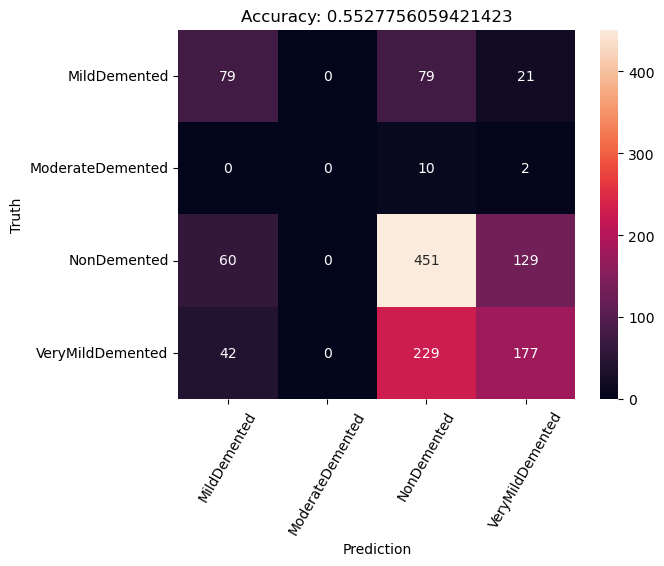

In [28]:
logistic_regression = LogisticRegression(**logistic_regression_best_params)

logistic_regression.fit(df, labels)

show_metrics(test_labels, logistic_regression.predict(test_df), classes=classes)

Ok, the results aren't as different from the results of the initial model, except for the single correct prediction of a moderate demented image.

Generally, we can see that the logistic regression models are having trouble distinguishing very mild and non demented samples (they're sequential in the dementia levels), and somewhat the mild demented and the non demented (which are not sequential).

Also, the moderate demented classes is being "thought of" as non or very mild demented, even though we tweaked the classes weights for the model. The conclusion here is that the model is not best suited for the classification given the newly created data, even though the results are more assuring!

Now let's try tree-based models, which, as we know, can be more complex, and given the current dataset, we expect better results than the results yielded previously.

Random Forest:

This time we won't be creating an initial model, and dive straight into the hyperparameters search.

In [29]:
from sklearn.ensemble import RandomForestClassifier

def rfc_custom_objective(trial):
    params = initialize_custom_hyperparameters(
        trial=trial,
        params={
            'n_estimators': ['int', [128, 256]],
            'max_depth': ['categorical', [None, 16, 32, 48]],
            'n_jobs': ['categorical', [-1]],
            'class_weight': ['categorical', [class_weights]],
            'random_state': ['categorical', [random_state]]
        }
    )
    rfc = RandomForestClassifier(**params)

    rfc.fit(df, labels)
    predictions = rfc.predict(test_df)
    # calculating accuracy as tuning parameter
    return (predictions == test_labels).sum() / predictions.shape[0]

In [30]:
study = custom_optimize('rfc', rfc_custom_objective, n_trials=10)
rfc_best_params = study.best_trial.params

  0%|          | 0/10 [00:00<?, ?it/s]

Total Accuracy: 0.5379202501954652

Precision: 
MildDemented: 1.0
ModerateDemented: 0.0
NonDemented: 0.5318066157760815
VeryMildDemented: 0.5760869565217391

Recall: 
MildDemented: 0.0446927374301676
ModerateDemented: 0.0
NonDemented: 0.9796875
VeryMildDemented: 0.11830357142857142

F1 Score: 
MildDemented: 0.0855614973262032
ModerateDemented: 0.0
NonDemented: 0.6893897746014294
VeryMildDemented: 0.1962962962962963



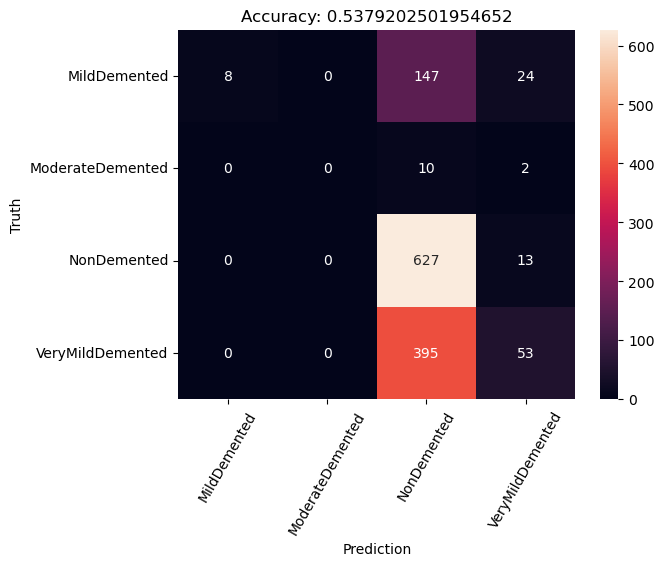

In [31]:
rfc = RandomForestClassifier(**rfc_best_params)
rfc.fit(df, labels)

test_preds = rfc.predict(test_df)
show_metrics(test_labels, test_preds, classes=classes)

That's surprising. The accuracy is higher than the logistic regression's, and we do see some very high precision in the mild demented class and a high recall score in the non demented class, which indicates the model is very confident with the non demented class. Also, the moderate demented class is way off the mark.

This time, the model predicted a lot of very mild demented as non demented, but not the other way around as well like the logistic regression model. Given that, the recall is very high for the non demeneted.

As for the mild demented, it didn't classify a lot of the samples as such, but out the ones it did, it scored very nicely, hence the high precision.

So overall the model had a hard time mainly with the mild demented and moderate demented, while confusing very mild demented with non demented, which we saw with previous models as well.

The conclusion here is the same as the logistic regression's, so let's try XGBoost, but this time we won't be searching hyperparameters, we'll only be training a model with the same parameters as our previous attempt since it takes a really long time to train. This is reasonable since we don't expect it to be used as our final classification model.

XGBoost:

In [32]:
from xgboost import XGBClassifier

def xgboost_custom_objective(trial):
    params = initialize_custom_hyperparameters(
        trial=trial,
        params={
            'n_estimators': ['int', [128, 256]],
            'max_depth': ['categorical', [None, 16, 32, 48]],
            'max_leaves': ['categorical', [0]],
            'learning_rate': ['float', [1e-4, 1e-2]],
            'grow_policy': ['categorical', ['depthwise']],
            'tree_method': ['categorical', ['exact']],
            'booster': ['categorical', ['gbtree']],
            'objective': ['categorical', ['multi:softmax']],
            'n_jobs': ['categorical', [-1]],
            'class_weight': ['categorical', [class_weights]],
            'random_state': ['categorical', [random_state]],
            # 'device': ['categorical', ['cuda']]
        }
    )
    xgb_classifier = XGBClassifier(**params)

    xgb_classifier.fit(df, labels)
    predictions = xgb_classifier.predict(test_df)
    # calculating accuracy as tuning parameter
    return (predictions == test_labels).sum() / predictions.shape[0]

In [33]:
# study = custom_optimize('xgboost', xgboost_custom_objective, n_trials=10)
# xgb_best_params = study.best_trial.params
xgb_best_params = {
    'learning_rate': 0.009899772001328156,
    'max_depth': None,
    'n_jobs': -1,
    'n_estimators': 256,
    'max_leaves': 0,
    'growpolicy': 'depthwise',
    'booster': 'gbtree',
    'class_weight': class_weights,
    'objective': 'multi:softmax',
    'random_state': random_state
}

In [34]:
xgb_classifier = XGBClassifier(**xgb_best_params)
xgb_classifier.fit(df, labels)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              class_weight={0: 1.7855648535564854, 1: 24.620192307692307,
                            2: 0.50009765625, 3: 0.7144252232142857},
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, growpolicy='depthwise',
              importance_type=None, interaction_constraints=None,
              learning_rate=0.009899772001328156, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=0,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=256, n_jobs=-1, ...)

Total Accuracy: 0.22439405785770133

Precision: 
MildDemented: 0.24826629680998613
ModerateDemented: 0.0
NonDemented: 0.19494584837545126
VeryMildDemented: 0.0

Recall: 
MildDemented: 1.0
ModerateDemented: 0.0
NonDemented: 0.16875
VeryMildDemented: 0.0

F1 Score: 
MildDemented: 0.3977777777777778
ModerateDemented: 0.0
NonDemented: 0.18090452261306533
VeryMildDemented: 0.0



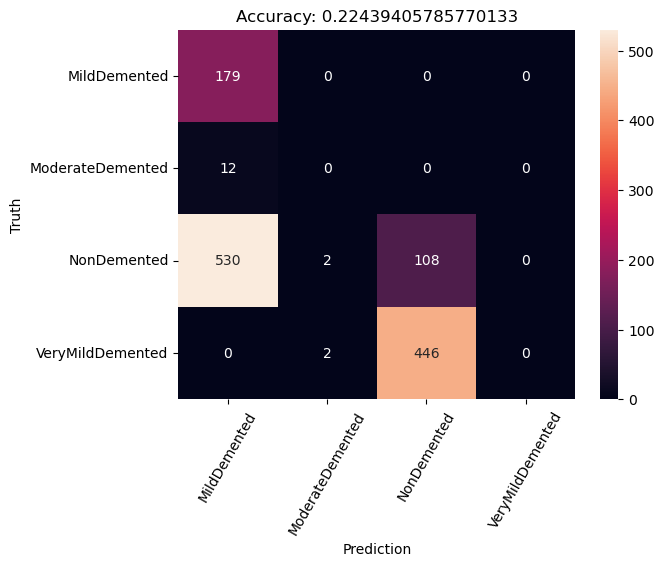

In [35]:
test_preds = xgb_classifier.predict(test_df)
show_metrics(test_labels, test_preds, classes=classes)

Mmm okay... The model predicted mild demented perfectly (best recall), but it thought that moderate and non demented are also mild demented. So we're seeing some sort of a drift towards the mild demented class in 3 classes.

Also, it was also hard for it distinguish non demented and very mild demented, as the other models were. So all in all, the accuracy is very low but we see only a single positive metric, which is the mild demented's recall, so obviously we can be sure that this model doesn't align with our goal. It's a possibility that tuning it further could lead to better results, but since time is of the essence, and the GPU is stronger than the CPU, we'll go and say that these models aren't the best for this dataset.

This leads us to the next section - modifying the dataset.

Since our dataset contains the original and augmented data (which was pixelated), there's a difference in appearance (and actual values) between the two. It would be best to try and make the augmented data as similar as possible to the original, as a post processing phase.

One approach to do that is to perform noise cleaning on the data. Since the images are pixelated, there's a strong change in values between neighboring pixels, which makes the image looks blocky. This block effect can also be treated as noise, which can be eliminated, to a degree, while keeping the overall structure and characteristics very similar to the original (pixelated image). This will cause it to be more similar to the actual original images, which what the augmeneted images were supposed to be.

So our solution to this so called problem is described next.

Since we can't "remove" entirely the blurriness and pixelated look of the the images, we'll need to settle with a tradeoff of a cleaner look with a low-resolution brain image, to still be able to see the main characteristics and attributes of the brain. 

For this case, I've decided to use the SVD (Singular Value Decomposition) algorithm, which is decomposing the flattened images matrix (flattening the `xy` axes to a single `y` axis), let's call it $A$, to get the $U$, $S$ and $V^*$ matrices, where $U$ and $V^*$ are unitary matrices and $V^*$ is the conjugate transpose of $V$ such that $A = U \cdot S \cdot V^*$.

$S$ is a diagonal (`numpy` returns a vector) matrix with the singular values of $A$ in a descending order.

$U$'s and $V^*$'s columns are orthonormal bases due to them being unitary matrices. 

$U \in \mathbb{R}^{mxm}$ where $m = images.shape[0]$, i.e: $m$ = number of images,

$V \in \mathbb{R}^{nxn}$ where $n = images.shape[1]*image.shape[2] = 176*144 = 25344$ 

and $S \in \mathbb{R}^{mxn}$. 

Generally, they're all supposed to uphold $\in \mathbb{C}^{k_1 x k_2}$, with the relevant $k1$ and $k2$ values, but since $A$ is real, they are as well.

So this algorithm can help us use the $S$ diagonal matrix to use the bigger singular values of $A$ that represent "feature importance" in $A$ to filter out "non important" features and in that, clean some noise.

It is important to say the the SVD is not unique, except for the singular values, i.e: $S$ is unique but $U$, $V^*$ aren't.

NOTE: it takes a long time to compute so we've cached it for using the same data across different runs of the notebook (using the same data from the augmentation notebook).

In [36]:
if not os.path.exists(f'{data_dir}/svd.h5'):
    print('Calculating singular values and singular vectors of the flattened images matrix...')
    # 40 mins to calculate on i9 13th generation
    U, S, V_t = np.linalg.svd(images.reshape(images.shape[0], -1), full_matrices=False)

    print('Saving U, S, V_t to disk...')
    with h5py.File(f'{data_dir}/svd.h5', 'w') as f:
        f.create_dataset('U', data=U)
        f.create_dataset('S', data=S)
        f.create_dataset('V_t', data=V_t)
else:
    with h5py.File(f'{data_dir}/svd.h5') as f:
        U = f['U'][:]
        S = f['S'][:]
        V_t = f['V_t'][:]

Calculating singular values and singular vectors of the flattened images matrix...
Saving U, S, V_t to disk...


In [37]:
U.shape, S.shape, V_t.shape

((30726, 25344), (25344,), (25344, 25344))

We'll have $S.shape[0] = 176 \cdot 144 = 25344$) singular values and we care only for a certain percent of them, where the remaining singular values (and vectors) will be zeroed out to perform some sort of noise cleaning

In [38]:
k = int(0.05 * S.shape[0])
k

1267

Here we're actually performing the noise cleaning. Since $A = U \cdot diag(S) \cdot V^*$, we'll always get a matrix $A' \in \mathbb{R}^{mxn}$.

And for that, we can control which "part" of the matrices will be multiplied since we don't want to fully recover our $A$ matrix.

This is why we've calculated $k$ to use only $5 \%$ of the singular values to perform a massive cleaning.

In [39]:
# svd_images = torch.bmm(U[..., :k], torch.bmm(torch.diag_embed(S[:, :k]), V_t[:, :k, :]))
svd_images = U[..., :k] @ (np.diag(S[..., :k]) @ V_t[..., :k, :])
svd_images = svd_images.reshape(*images.shape)

In [40]:
svd_images.shape

(30726, 176, 144)

Now for the normalization to the $[0, 255]$ range of the restored images from the `SVD` process.

In [41]:
svd_images[generated_images_start_idx:].min(), svd_images[generated_images_start_idx:].max()

(-21.339203614256316, 244.54126819484634)

In [42]:
svd_images[generated_images_start_idx:] = normalize_images(svd_images[generated_images_start_idx:], lib=np)

Let's visualize the cleaned images.

Text(0.5, 1.0, 'Generated Image After SVD')

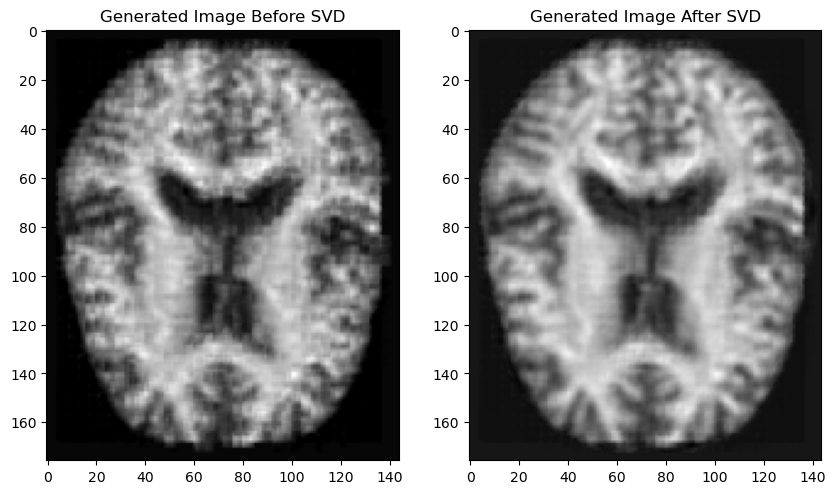

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(images[-1], cmap='gray')
axes[0].set_title('Generated Image Before SVD')
axes[1].imshow(svd_images[-1], cmap='gray')
axes[1].set_title('Generated Image After SVD')

As we can see, a large amount of noise was cleaned, the blurriness level dropped while keeping the relevant data of the image. Also, we did get a "low-resolution" image as we initially wanted.

In [44]:
# replacing the existing blurry images with the svd ones
images[generated_images_start_idx:] = svd_images[generated_images_start_idx:]

Now that we have our dataset, let's try and repeat the same process we did with the initial augmented dataset to be sure the noise cleaning helped.

Let's create the new datasets using the clean images.

In [45]:
df, df_cols_to_drop, df_cols_means, df_cols_stds = create_dataset(images, labels, **dataset_params, is_train=True)
test_df = create_dataset(test_images, test_labels, **dataset_params, means=df_cols_means, stds=df_cols_stds, drop_cols=df_cols_to_drop, boundary_pixels=(16, 191, 159, 16), is_train=False)

# using the labels variable instead
df.drop('class', axis=1, inplace=True)
test_df.drop('class', axis=1, inplace=True)

We'll skip the hyperparameters search and see whether the same models we created perform better on the current dataset. This won't necessarily give us an exact answer, but is can give us an idea whether the noise cleaning was justified, in a sense.

Logistic Regression:

In [46]:
from modules.models.utils import show_metrics

In [47]:
logistic_regression = LogisticRegression(**logistic_regression_best_params)
logistic_regression.fit(df, labels)

LogisticRegression(C=2.3461629030738753,
                   class_weight={0: 1.7855648535564854, 1: 24.620192307692307,
                                 2: 0.50009765625, 3: 0.7144252232142857},
                   l1_ratio=0.7762675066841126, multi_class='ovr', n_jobs=-1,
                   penalty=None, random_state=42)

Total Accuracy: 0.5027365129007036

Precision: 
MildDemented: 0.4423076923076923
ModerateDemented: 1.0
NonDemented: 0.5548469387755102
VeryMildDemented: 0.40828402366863903

Recall: 
MildDemented: 0.3854748603351955
ModerateDemented: 0.08333333333333333
NonDemented: 0.6796875
VeryMildDemented: 0.3080357142857143

F1 Score: 
MildDemented: 0.41194029850746267
ModerateDemented: 0.15384615384615385
NonDemented: 0.6109550561797753
VeryMildDemented: 0.3511450381679389



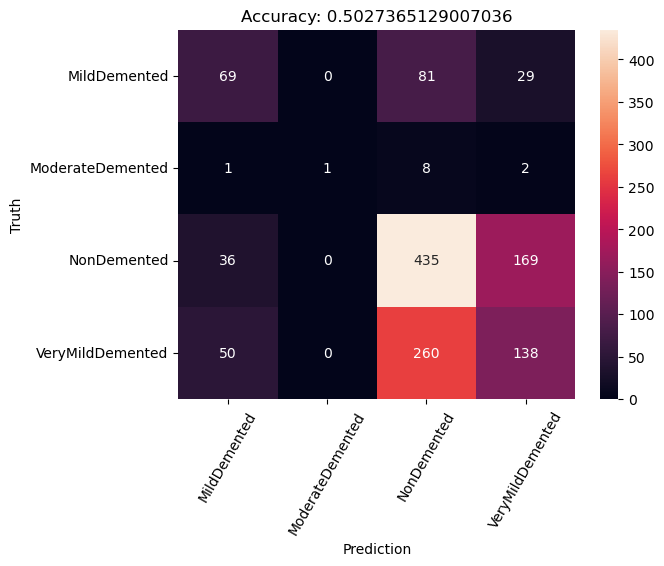

In [48]:
test_preds = logistic_regression.predict(test_df)
show_metrics(test_labels, test_preds, classes=classes)

Random Forest:

Total Accuracy: 0.547302580140735

Precision: 
MildDemented: 1.0
ModerateDemented: 0.0
NonDemented: 0.5384615384615384
VeryMildDemented: 0.6285714285714286

Recall: 
MildDemented: 0.0223463687150838
ModerateDemented: 0.0
NonDemented: 0.984375
VeryMildDemented: 0.14732142857142858

F1 Score: 
MildDemented: 0.04371584699453552
ModerateDemented: 0.0
NonDemented: 0.6961325966850829
VeryMildDemented: 0.23869801084990958



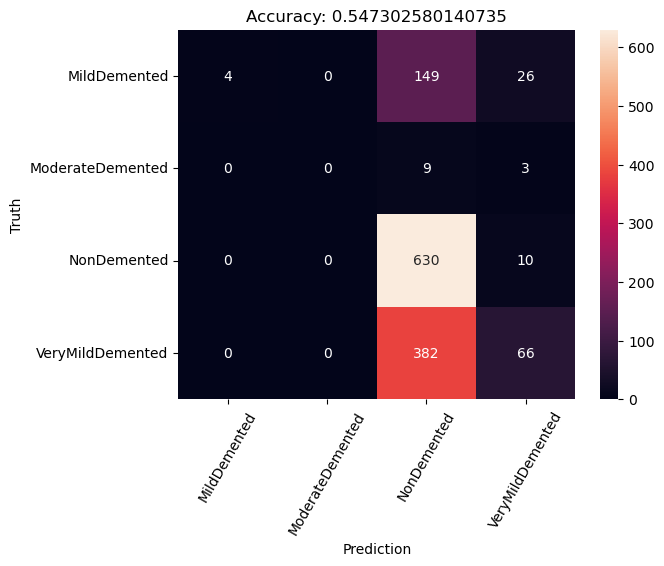

In [49]:
rfc = RandomForestClassifier(**rfc_best_params)
rfc.fit(df, labels)

test_preds = rfc.predict(test_df)
show_metrics(test_labels, test_preds, classes=classes)

XGBoost:

Total Accuracy: 0.2259577795152463

Precision: 
MildDemented: 0.24826629680998613
ModerateDemented: 0.0
NonDemented: 0.19748653500897667
VeryMildDemented: 0.0

Recall: 
MildDemented: 1.0
ModerateDemented: 0.0
NonDemented: 0.171875
VeryMildDemented: 0.0

F1 Score: 
MildDemented: 0.3977777777777778
ModerateDemented: 0.0
NonDemented: 0.18379281537176273
VeryMildDemented: 0.0



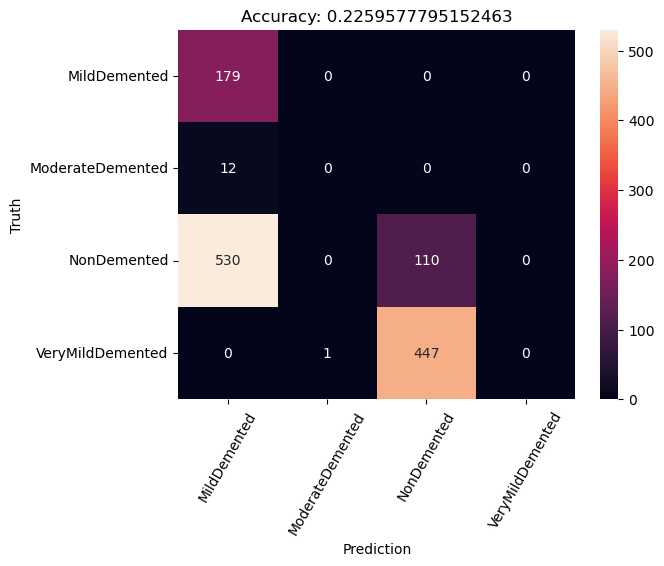

In [50]:
xgb_classifier = XGBClassifier(**xgb_best_params)
xgb_classifier.fit(df, labels)

test_preds = xgb_classifier.predict(test_df)
show_metrics(test_labels, test_preds, classes=classes)

Conclusions:

Surprisingly, the random forest model performed the best out of the three, where it performed very well on the non demented class, in comparison to logistic regression and xgboost where they performed pretty bad on that class.

What also surprised me is that the xgboost model had the worst results by a great margin, where it is known for its' high performances on tabular data such as we created. But that can be due to the time we saved of not executing a hyperparameters search.

Overall, all three models have a fairly similar results to their respective models using the non cleaned dataset, where the most noticeable one is the logistic regression model, where it performed slightly better. Due to that, we can continue trying to use the cleaned dataset as our final dataset to feed it into our final model. So with that being said, those results aren't satisfactory at all, achieving very low metric scores in most of the classes (in terms of precision, recall and accuracy), in a problem where the outcome can be very dramatic for a given patient's life.

From here we'll go with trying a more complex model, which tries to use the augmentation model we've trained previously, which ideally extracted very important features from the dataset (with some constraints such as regularization), and we will be fine tuning it (or retrain it from its' last training point) to try and predict the classes in the dataset.

So our approach here is to use the AutoEncoder we used, knowing it has the ability to compress a given image into a smaller latent space, extracting important features which can be used to retrieve that image from the latent space. So our logic here is to use those features and try and predict from them the correct classes.

Since this model is mostly trained, making the trained weights non-trainable will speed up the training process and the backpropagation will be calculated and applied only on the newly attached parameters in the network.

Let's begin with creating the train and validation datasets for the model.

In [51]:
import torch
import torch.nn as nn

import modules.models
from modules.models.models import ConvClassifier
from modules.models.dataset import AlzheimerDataset

import modules.db
from modules.db.optuna_report import get_best_hyperparameters

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Same as with the augmentation, we'll create a train and validation datasets for the training evaluation.

In [53]:
perm = torch.randperm(images.shape[0])
val_indices = perm[:int(images.shape[0] * 0.15)].numpy()
train_indices = np.setdiff1d(np.arange(images.shape[0]), val_indices)

In [54]:
# using the same training and validation datasets from the autoencoder training
train_dataset = AlzheimerDataset(images[train_indices], labels[train_indices])
val_dataset = AlzheimerDataset(images[val_indices], labels[val_indices])

Since we know the `randperm` function distributes the data in a similar distribution (as we've seen in the augmentation notebook), we'll stick with it here.

Now to fine tune the model, we need its' exact parameters used to define its overall architecture, and obviously the weights' values across the network to be able to load it to memory.

The next step is to initialize our `classifier` using only the encoder (since the decoder isn't relevant here), and since we saved our model as a file at the end of the previous notebook, with all the relevant parameters in its name, we can parse that name later on, given we have the parameters.

So I've decided to use the best model in all of my attempts, and not the one from the last study, and for that I'm fetching its parameters from the database.

In [55]:
params = get_best_hyperparameters(from_last_study=False) # get hyperparameters from the study, if studied

train_best_params = params
train_best_params['lr'] = train_best_params['learning_rate']

Again, some helper functions for the training process.

In [56]:
def train_epoch(model, optimizer, loss, dataloader, val_dataset, overall_losses, val_overall_losses, accuracy, val_accuracy, epoch, scheduler=None, writer=None):
    for _, (batch_X, batch_y) in enumerate(dataloader):
        batch_X = batch_X.to(device=model.device)
        batch_y = batch_y.to(device=model.device)

        # model expects at least 2 samples in a batch
        if batch_X.shape[0] == 1:
            batch_X = torch.concat((batch_X, batch_X), dim=0).to(device=model.device)
            batch_y = torch.concat((batch_y, batch_y), dim=0).to(device=model.device)
        
        optimizer.zero_grad()
        
        batch_output = model(batch_X)
        batch_loss = loss(batch_output, batch_y)
        overall_losses[epoch] += batch_loss.item()

        predictions = torch.argmax(batch_output, dim=1).to(model.device)
        accuracy[epoch] += (predictions == batch_y).sum().item()
    
        batch_loss.backward()
        optimizer.step()
    
    # updating train metrics
    overall_losses[epoch] /= dataloader.dataset.y.shape[0]
    accuracy[epoch] /= dataloader.dataset.y.shape[0]

    if writer:
        writer.add_scalar('Overall Loss/Train', overall_losses[epoch], epoch)
        writer.add_scalar('Accuracy/Train', accuracy[epoch], epoch)
        
    # validation
    with torch.no_grad():
        model.eval()
        val_output = model(val_dataset.X.to(model.device))
        loss_value = loss(val_output, val_dataset.y.to(model.device))

        val_overall_losses[epoch] = loss_value.item() / val_dataset.y.shape[0]

        predictions = torch.argmax(val_output, dim=1).to(model.device)
        val_accuracy[epoch] = (predictions == val_dataset.y.to(model.device)).sum().item() / predictions.shape[0]

        if writer:
            writer.add_scalar('Overall Loss/Validation', val_overall_losses[epoch], epoch)
            writer.add_scalar('Accuracy/Validation', val_accuracy[epoch], epoch)

    # update learning rate after each epoch to have equal effect for every batch
    if scheduler is not None:
        scheduler.step()
    

In [57]:
from tqdm.notebook import tqdm

import modules.db
from modules.db.optuna_report import report_optuna_trial, get_last_study_id

# using tensorboard for the visualizations and progress of the trials
from torch.utils.tensorboard import SummaryWriter
import optuna

In [58]:
classification_studies_dir = './data/studies/classification'
if not os.path.isdir(classification_studies_dir):
    os.mkdir(classification_studies_dir)
studies_directories = os.listdir(classification_studies_dir)
# if last study wasn't finished, use that study id in tensorboard and later on in resuming the optuna study
if len(studies_directories) > 0:
    current_study_id = studies_directories[-1].split('-')[-1]
# last study finished successfully so we'll start a brand new one
else:
    current_study_id = get_last_study_id()
current_study_id

79

In [59]:
# if trial is None we're going for multi-objective optimization or we're normally training
def train(trial, model, optimizer, loss, epochs, dataloader, val_dataset, scheduler=None, plot=True, show_progress=True):
    log_dir = f'./logs/classification/study-{current_study_id}/trial-{trial.number}' if trial else f'./logs/classification/study-{current_study_id}/final'
    writer = SummaryWriter(log_dir=log_dir)

    writer.add_graph(model, next(iter(dataloader))[0].to(device=model.device))
    
    overall_losses, val_overall_losses = torch.zeros(epochs), torch.zeros(epochs)
    accuracy, val_accuracy = torch.zeros(epochs), torch.zeros(epochs)
    
    # using tqdm has conflicts with optuna's study progress bar
    epochs_range = tqdm(range(epochs)) if show_progress else range(epochs)
    for epoch in epochs_range:
        model.train()
        
        train_epoch(
            model=model,
            optimizer=optimizer, 
            loss=loss,
            epoch=epoch,
            dataloader=dataloader,
            val_dataset=val_dataset,
            val_overall_losses=val_overall_losses,
            accuracy=accuracy,
            val_accuracy=val_accuracy,
            overall_losses=overall_losses,
            scheduler=scheduler,
            writer=writer
        )

        writer.flush()
        
        if trial is not None:
            trial.report(overall_losses[epoch].item(), epoch)

            if trial.should_prune():
                writer.close()
                raise optuna.TrialPruned()

    if plot:
        fig, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(16, 10))
        
        axes[0].plot(overall_losses.cpu(), color='blue', label='Train')
        axes[0].plot(val_overall_losses.cpu(), color='orange', label='Validation')
        axes[0].set_title('Overall Loss')
        axes[0].legend()

        axes[1].plot(accuracy.cpu(), color='blue', label='Train Accuracy')
        axes[1].plot(val_accuracy.cpu(), color='orange', label='Validation Accuracy')
        axes[1].set_title('Accuracy')
        axes[1].legend()

    # writer.flush()
    writer.close()
    
    return (overall_losses, val_overall_losses), (accuracy, val_accuracy)

Our loss function here is different from the augmentation one, since we're using supervised learning, and we want to train a classifier, our basic options are `CrossEntropyLoss` and `NLLLoss`. 

Naturally, I've decided to let Optuna choose which one is best.

But note that we're not using the "vanilla" arguments. We're calculating a weights vector for each of the classes and letting the loss function use those weights when calculating the loss value. This will try and balance the minority classes by giving them a larger weight when calculating the gradients, and will do the opposite for the majority classes, the same as we did with the above ML models (logistic regression and the tree based models).

In [60]:
def get_classification_loss_function(idx, weighted_loss=True, reduction='mean', device='cpu'):
    if weighted_loss:
        # getting the distribution of data
        _, counts = np.unique(labels, return_counts=True)
        counts = counts.astype(np.float32)
        for i in range(len(counts)):
            counts[i] = counts.sum() / (len(counts) * counts[i])
        # giving minority classes larger weights
        weights = torch.from_numpy(counts).to(dtype=torch.float32, device=device)
        return nn.CrossEntropyLoss(reduction=reduction, weight=weights) if idx == 0 else nn.NLLLoss(reduction=reduction, weight=weights)
    # not weighted loss
    return nn.CrossEntropyLoss(reduction=reduction) if idx == 0 else nn.NLLLoss(reduction=reduction)

NOTE: I've tweaked the values here from the augmentation notebook, again, after trial and error, and I've added a `fine_tune` parameter for deciding whether we want to actually fine tune the `encoder` or retrain its' weights.

There's an option to use different optimizer parameters for the `encoder` model, and specific ones for the `classifier`'s parameters, in the `optimizer` initialization, which will probably be best, but currently I couldn't think of the values that will be given to the `encoder` parameters.

In [61]:
def initialize_hyperparameters(trial):
    lr = trial.suggest_float('lr', 1e-8, 1e-1, log=True)
    weight_decay = trial.suggest_float('weight_decay', 0, 0.1)
    beta1 = trial.suggest_float('beta1', 0.5, 0.999)
    beta2 = trial.suggest_float('beta2', 0.5, 0.999)

    momentum = trial.suggest_float('momentum', 0, 0.75)
    dampening = trial.suggest_float('dampening', 0, 0.3)

    optimizer_idx = trial.suggest_int('optimizer_idx', 0, 1)

    scheduler_gamma = trial.suggest_float('scheduler_gamma', 0.6, 0.999)

    fine_tune = trial.suggest_categorical('fine_tune', [True, False])
    
    # lower the number of epochs when retraining the encoder to avoid overfitting
    if not fine_tune:
        epochs = trial.suggest_int('epochs', 4, 25)
    else:
        epochs = trial.suggest_int('epochs', 32, 72)
    
    batch_size = trial.suggest_int('batch_size', 32, 256)

    loss_function_id = trial.suggest_int('loss_function_id', 0, 1)
    reduction = trial.suggest_categorical('reduction', ['sum'])

    weighted_loss = trial.suggest_categorical('weighted_loss', [True, False])

    relu_slope = trial.suggest_float('relu_slope', 0, 0.2)
    linear_blocks = trial.suggest_categorical('linear_blocks', [True, False])

    return lr, weight_decay, (beta1, beta2), momentum, dampening, optimizer_idx, scheduler_gamma, epochs, \
        batch_size, loss_function_id, reduction, fine_tune, weighted_loss, relu_slope, linear_blocks

In [62]:
def objective(trial):
    (lr,
     weight_decay,
     betas,
     momentum,
     dampening,
     optimizer_idx,
     scheduler_gamma,
     epochs,
     batch_size,
     loss_function_id,
     reduction,
     fine_tune,
     weighted_loss,
     relu_slope,
     linear_blocks) = initialize_hyperparameters(trial)
    
    model = ConvClassifier(train_params=train_best_params, num_classes=len(np.unique(labels)),
                           relu_slope=relu_slope, device=device, fine_tune=fine_tune, linear_blocks=linear_blocks).to(device)
    # trainable_parameters = [param for name, param in model.named_parameters() if name.startswith('seq_')]

    if optimizer_idx == 0:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay, betas=betas)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, dampening=dampening)
    
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_gamma)
    loss = get_classification_loss_function(loss_function_id, weighted_loss, reduction, device=model.device)
    
    dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    overall, _ = train(
        model=model,
        optimizer=optimizer,
        loss=loss,
        epochs=epochs,
        dataloader=dataloader,
        val_dataset=val_dataset,
        scheduler=scheduler,
        plot=False,
        show_progress=False,
        trial=trial
    )
    
    overall_train_losses, val_overall_losses = overall
    
    # saving the best trained model exploded the VRAM so we'll have to do with the best parameters and then retrain 
    # trial.set_user_attr(key='best_booster', value=autoencoder)
    
    return val_overall_losses[-1].item() # overall_train_losses[-1].item()

In [63]:
def multi_objective(trial):
    (lr,
     weight_decay,
     betas,
     momentum,
     dampening,
     optimizer_idx,
     scheduler_gamma,
     epochs,
     batch_size,
     loss_function_id,
     reduction,
     fine_tune,
     weighted_loss,
     relu_slope,
     linear_blocks) = initialize_hyperparameters(trial)
    
    model = ConvClassifier(train_params=train_best_params, num_classes=len(np.unique(labels)),
                           relu_slope=relu_slope, device=device, fine_tune=fine_tune, linear_blocks=linear_blocks).to(device)
    # trainable_parameters = [param for name, param in model.named_parameters() if name.startswith('seq_')]

    if optimizer_idx == 0:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay, betas=betas)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, dampening=dampening)

    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_gamma)
    loss = get_classification_loss_function(loss_function_id, weighted_loss, reduction, device=model.device)
    
    dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    overall, _ = train(
        model=model,
        optimizer=optimizer,
        loss=loss,
        epochs=epochs,
        dataloader=dataloader,
        val_dataset=val_dataset,
        scheduler=scheduler,
        plot=False,
        show_progress=False,
        trial=None
    )
    
    overall_train_losses, val_overall_losses = overall
    # train_accuracy, val_accuracy = accuracy
    
    # TODO: check BCE vs NLLLoss scales
    return overall_train_losses[-1].item(), val_overall_losses[-1].item()

In [64]:
def callback(study, trial):
    report_optuna_trial(study, trial)

In [65]:
def optimize(is_multi_objective, n_trials=100):
    directions = ['minimize', 'minimize'] if is_multi_objective else ['minimize']
    objective_func = multi_objective if is_multi_objective else objective
    study = optuna.create_study(directions=directions)
    study.optimize(objective_func, n_trials=n_trials, timeout=3600*(n_trials // 30), show_progress_bar=True, gc_after_trial=True) # , callbacks=[callback])
    return study

We'll be starting the study with a rather large number of trials to try and find the best possible combination for the classification problem.

In [66]:
is_multi_objective = False
n_trials = 100
study = optimize(is_multi_objective=is_multi_objective, n_trials=n_trials)

  0%|          | 0/100 [00:00<?, ?it/s]

In [67]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [68]:
import optuna.visualization as vis

Since the results in the below plots are non-deterministic across studies, I'll just note that for the specific study I've ran, we're seeing some unexpected parameters with the highest importances, like `beta1`.

In [69]:
vis.plot_param_importances(study)

In [70]:
if is_multi_objective:
    fig = vis.plot_optimization_history(study, target=lambda t: t.values[0], target_name='Loss')
    fig.show()

In [71]:
if is_multi_objective:
    fig = vis.plot_optimization_history(study, target=lambda t: t.values[1], target_name='Accuracy')
else:
    fig = vis.plot_optimization_history(study)
fig.show()

As we can see, the study started with a rather high objective function value (high loss value, which is not good), but slowly and steadily had a downward trend to lower the loss value. It is reasonable to assume that using a higher number of trials might have find a better combination of hyperparameters, although we can't be certain that the results would be strongly affected by it.

In [72]:
if is_multi_objective:
    fig = vis.plot_slice(study, target=lambda t: t.values[0], target_name='Loss')
    fig.show()

In [73]:
if is_multi_objective:
    fig = vis.plot_slice(study, target=lambda t: t.values[1], target_name='Accuracy')
else:
    fig = vis.plot_slice(study)
fig.show()

In terms of hyperparameters behavior across the studies and trials, we can observe and notice several things:

* The larger the batch size, dampening and weight decay, the lower the objective function's value is.
* The opposite can be said on epochs, learning rate, momentum, relu slope and scheduler gamma.
* The momentum (beta1 when using `Adam` optimizer) has a very specific range where the objective function is more optimized.
* The class weights contributed to the objective function's optimization.
* The better loss function is the `NLLLoss`.

From here we can try and lower the learning rate, since it seems like it should be closer to 0.

We can lower the scheduler gamma value, but be wary of the lower learning rate value to not make it numerically unstable.

We'll summarize and say that after each run of this notebook, I've modified the ranges values of each parameter according to the results from this plot, so as the studies across multiple different executions being non deterministic, it is not 100% accurate.

Now that we have a set of hyperparameters, let's use them to create the final model and train it.

In [74]:
if is_multi_objective:
    best_trials = study.best_trials
    sorted_trials = sorted([(trial.values[1], trial.params) for trial in best_trials])
    best_params = sorted_trials[0][1]
else:
    best_params = study.best_trial.params
best_params

{'lr': 0.003261673372000826,
 'weight_decay': 0.04181827426072306,
 'beta1': 0.6158383783327439,
 'beta2': 0.6414727479117825,
 'momentum': 0.09871082557299417,
 'dampening': 0.07985078151227293,
 'optimizer_idx': 0,
 'scheduler_gamma': 0.7928180534296096,
 'fine_tune': False,
 'epochs': 15,
 'batch_size': 198,
 'loss_function_id': 1,
 'reduction': 'sum',
 'weighted_loss': True,
 'relu_slope': 0.12486769129839673,
 'linear_blocks': False}

In [75]:
lr = best_params['lr']
weight_decay = best_params['weight_decay']
betas = (best_params['beta1'], best_params['beta2'])
momentum = best_params['momentum']
dampening = best_params['dampening']
scheduler_gamma = best_params['scheduler_gamma']
batch_size = best_params['batch_size']
epochs = best_params['epochs']
relu_slope = best_params['relu_slope']
linear_blocks = best_params['linear_blocks']
fine_tune = best_params['fine_tune']
weighted_loss = best_params['weighted_loss']

# using the train_best_params like in the study for the encoder's architecture
model = ConvClassifier(train_params=train_best_params, num_classes=len(np.unique(labels)),
                       relu_slope=relu_slope, device=device, fine_tune=fine_tune, linear_blocks=linear_blocks).to(device)

# trainable_parameters = [param for name, param in model.named_parameters() if name.startswith('seq_')]
if best_params['optimizer_idx'] == 0:
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay, betas=betas)
else:
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, dampening=dampening)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_gamma)

loss_func = get_classification_loss_function(best_params['loss_function_id'], weighted_loss, best_params['reduction'], device=model.device)

In [76]:
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Training the final classifier model

  0%|          | 0/15 [00:00<?, ?it/s]

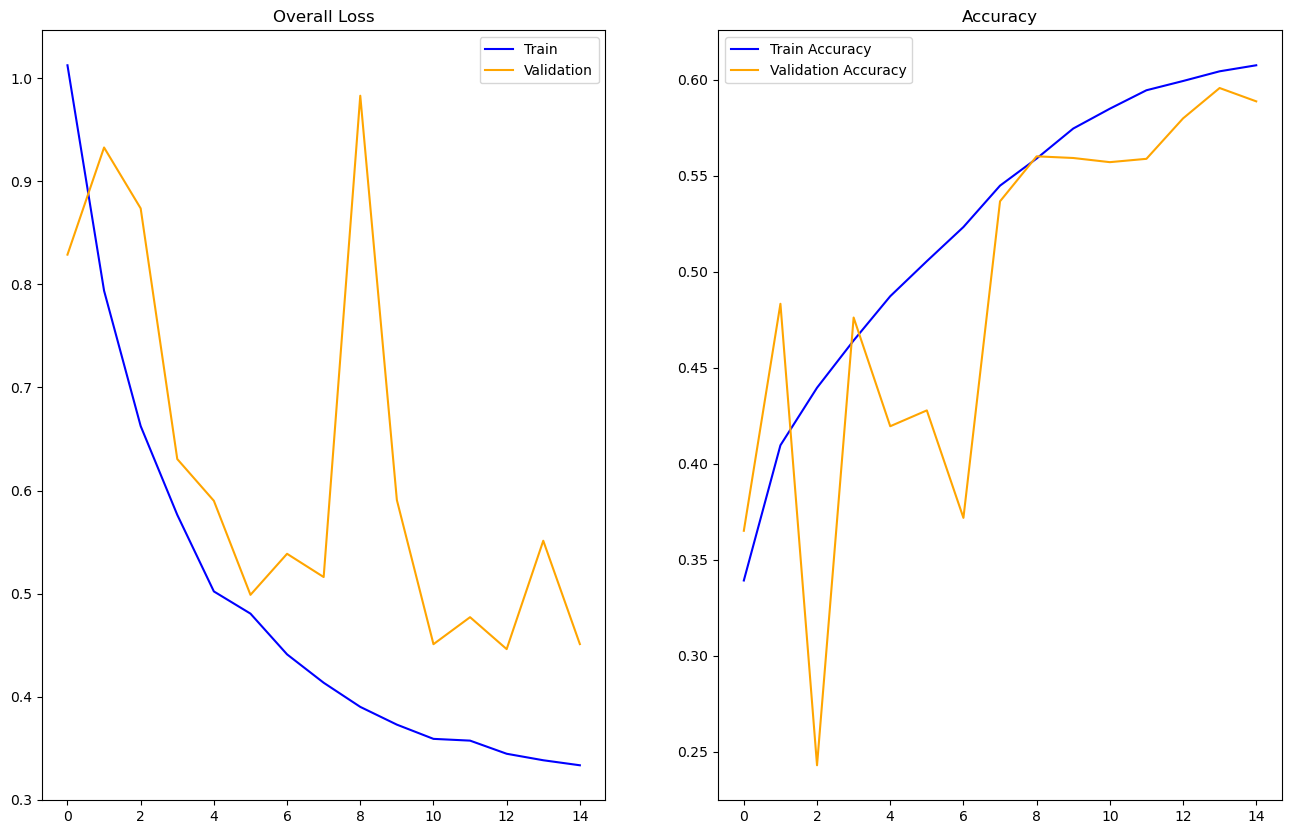

In [77]:
overall, accuracy = train(
    model=model,
    optimizer=optimizer,
    loss=loss_func,
    epochs=epochs,
    dataloader=dataloader,
    val_dataset=val_dataset,
    scheduler=scheduler,
    plot=True,
    show_progress=True,
    trial=None
)

As we can see, the results are not promising for a training process, even though the validation and training loss and accuracy are fairly similar, having the same tendentiousness after ~3 epochs.

Also, the similarity is very tight since the validation loss is very close to the training loss throughout the training process maintaining the same difference, which is good since we don't see a breaking point where the training loss keeps on decreasing in a drastically faster rate than the validation loss, which can indicate an overfit. Also, since this model is a supervised model, we don't want to reach that overfit point to be able to generalize well on the test data, which is not entirely what we aimed at using the augmentation model (as explained in the augmentation notebook).

If `fine_tune = False` then it's a good possibility that we've retrained our `encoder` using some of the data we've used to initially train it. Personally, I don't really like this idea, but we can look at it as we've added "more epochs" to the initial training, even though the backpropagation process is very different with our `classifier` model.

In the case where `fine_tune = True`, our training was done solely on the new layers we've added, which means the `encoder` weights and biases were left untouched, and for that the plot from above shows good promise, although after trial and error, it doesn't help exactly.

### Evaluation

Now for the evaluation of the trained model.

Since we're dealing with a problem that affects a human's life, there are some metrics which we should care about more than others, and even some that we wouldn't care at all.

Let's break it down first:
* Our dataset is very imbalanced, so using `accuracy` as a performance and evaluation metric isn't the way to go, since not predicting the minority class (and somehow predicting the correct one, which is safe to assume that predicting correctly is with a probability that's higher than $\frac{1}{3}$) will cause neglecting the minority class, which we'll never get right.
* We're predicting Alzheimer's dementia levels, meaning that for a given patient that is feared to have the disease, we'd rather predict it has a stronger level of dementia than a weaker one, for which we can treat the patient more carefully, if possible, and not underestimate the severity. I'm not 100% sure of the medical consequences but logically that's a good way to think about it.
* So from the above assumptions, we'd want to measure `precision` and `recall`.

To refresh our memory, `precision` means "from all the predictions I made for class X, how many did I predict as X and was correct?", i.e: `precision = tp / (tp + fp)`.

As for `recall`, it is somewhat similar to `precision`. I like to think of it as the `precision`'s transpose. `Recall` means "from all the samples from class X, how many did I predict as X and was correct?", i.e: `recall = tp / (tp + fn)`.

My observation at it would be that using the `confusion matrix`, the `precision` is the columns and the `recall` is the rows (where the `x axis` is the predictions and the `y axis` is the true values), hence the "transpose".

Also, since we care about `precision` and `recall`, it would be natural to also measure the `F1 score`, which is, according to Wikipedia, an "harmonic mean" of those two metrics. And just to be precise, $F_1 = \frac {2TP}{2TP + FP + FN} = 2 \cdot \frac{precision \cdot recall}{precision + recall}$, so the range here is $[0, 1]$, where $1$ is best and $0$ is worst.

If we want to give "more weight" to a specific metric, we can use the $F_\beta$ score, where $\beta$ is the weight for the `recall` such that $F_\beta = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\beta^2 \cdot precision + recall}$. $\beta$ can be higher than $1$. According to Wikipedia, "Two commonly used values for $\beta$ are $2$, which weighs `recall` higher than `precision`, and $0.5$, which weighs `recall` lower than `precision`."

So in our use case here, there are classes that are more important to have a high `recall` and some to have a high `precision`. So for now, we'll give both metrics the same "weight", or say $\beta = 1$, and use the $F_1$ score.

For that, there's an option to optimize our hyperparameters search trying to optimize each of those metrics, but that would be very compute and time intensive since all trials would run. So we'll decide to keep with the decision to optimize the validation's loss.

Creating the test dataset for the final evaluation

In [ ]:
model.eval()

leftmost_pixel, uppermost_pixel = 16, 16
rightmost_pixel, bottommost_pixel = 159, 191

test_images = test_images[:, uppermost_pixel:bottommost_pixel+1, leftmost_pixel:rightmost_pixel+1]

In [80]:
test_dataset = AlzheimerDataset(test_images, test_labels)

In [81]:
from modules.models.utils import show_metrics

Total Accuracy: 0.5856137607505864

Precision: 
MildDemented: 0.3761904761904762
ModerateDemented: 0.6666666666666666
NonDemented: 0.6619170984455959
VeryMildDemented: 0.53125

Recall: 
MildDemented: 0.441340782122905
ModerateDemented: 0.5
NonDemented: 0.7984375
VeryMildDemented: 0.34151785714285715

F1 Score: 
MildDemented: 0.40616966580976865
ModerateDemented: 0.5714285714285714
NonDemented: 0.7237960339943342
VeryMildDemented: 0.4157608695652174



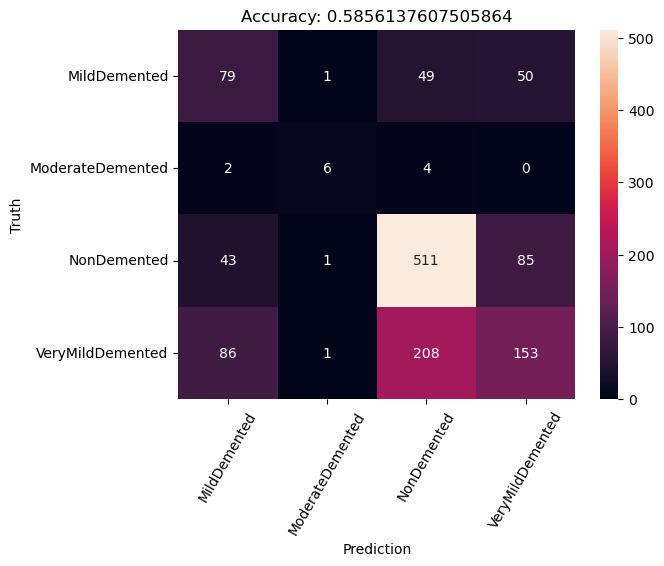

In [82]:
output = model(test_dataset.X.to(model.device))
test_preds = torch.argmax(output, dim=1).to(model.device)
test_preds = test_preds.cpu().numpy()
show_metrics(test_labels, test_preds, classes=classes)

The confusion matrix is not very assuring, but we see much better precision and recall scores across the classes, except for the very mild demented recall/precision and mild demented precision/recall. My guess is that the enforcement of the `KL Divergence` regularization term from the `AutoEncoder`'s training, missed a lot of important features when compressed to the latent space, in favor of making it normally distributed. So there's a tradeoff. This tradeoff is for the worst since our main use case for the model was augmentation, and not the "classic GenAI" use cases that's been going on in the last 3-4 years. So being able to sample from a latent space easily, with easy tweaks that can result in entirely different image, probably isn't the best way to go here, where the main focus should've been on the ability to sample from "some" latent space, regardless of its' distribution, where the sampling can be referred to a specific class (for the augmentation's next step, which is classification).

To easiest way to justify this approach would be to train a new `AutoEncoder` without the `KL Divergence` regularization term, and obviously, without the `reparameterization trick` in the `encoder`, and compare the results.

In any case, I believe that tuning the current model further wouldn't result in any better results, since we ran a large number of searches of hyperparameters, using multiple architectures on the current AutoEncoder's network, so the search spectrum was broad enough.

So my conclusion here can be divided into 2 scenarios:
* If the choice of using a VAE was correct then the problem might be in the data, perhaps the augmentation should've been focused on the classes that the model is having harder times. That's an important note since the moderate demented class is very very imbalanced and a minority, but the recall score is not that bad given the amount of samples we have. So my guess here looking backwards is to augment more of the hard-to-distinguish classes like non/very mild demented, even though the test and training data seems like they distributed the same.
* If the choice was wrong, then using a different architecture could always be a possibility of better results. Using more sophisticated models, that were trained on more similar data could be a good way to start justifying this hypothesis.

In [83]:
import shutil
try:
    shutil.rmtree(f'./logs/classification/study-{current_study_id}')
except Exception as e:
    print(e)

#### Potential solutions

* Use a trained network that was trained on medical data such as brain images, and fine tune it to this dataset. A very good option currently is to use a Vision Transformer. Unfortunately, due to lack of time I was unable to complete it on a good enough level to showcase it here.
* Perform a more robust and comprehensive EDA and understand the domain's limitations and more advanced legitimate assumptions (maybe taking the mirror image of each brain is really wrong!). Perform statistical analysis of the features extracted from the comprehensive EDA with the latent space (in case it wasn't a VAE) using tools like SHAP or other xAI tools.
* Try and use a differnet visual model and fine tune it, like ResNet.
* Scrape more data. As mentioned above, the problem might be in the data, so getting more of it is always a blessing in the data science world.

#### Results and conclusions

* The results for me are pretty disappointing. After working on such a large project for so long, with the motivation to possibly be able to help others and expecting good results, it wasn't the case. Nonetheless, this project taught me a lot on Computer Vision and problem solving. I used many techniques which I didn't learn in class, so I had to search and learn about them, which motivates self learning, which is a critical skill in this ongoing transformative field. I've found myself using various techniques from Image Processing course I learned in class, while enriching that knowledge in a more deeper sense when implemeting the theory.
* I used many algorithms and techniques that I did learn in the university, and for that I saw the potential and a real-life use case for those tools.
* Regarding the results themselves, this model is not fit for production use or any use case whatsoever, but I believe that with the right approach, this direction can be very promising (maybe neglect the Variational AutoEncoder approach and try the "regular" AutoEncoder or just use a Vision Transformer, which would probably be best due to its SOTA capabilities).

#### Compute and resources

* My compute was pretty intensive for a modern PC, using an Intel i9 13900 5GHz 24-core CPU, 32 GB of DDR5 RAM, 1TB NVME storage device and a NVIDIA RTX 4070 Super with 12 GB of VRAM, which made my life a lot easier so that I could work offline without paying for a Kaggle/Colab subscription, since the free tier GPUs performed slower, and obviously unlimited GPU time.
* For version control, I used Git and GitHub.
* For tracking my history and model's trainings and performances, I used an external PostgreSQL database using an API written in FastAPI for the reports during training, and TensorBoard for the visualizations during training.
* Most of the resources that I used in terms of ideas, explanations and code, were from Wikipedia (for a formal explanation and understanding), arXiv papers (mainly the `VAE`) and the "Deep Learning" and course by Dr. Idan Alter, "Intro to Machine Learning" course by Dr. Shay Maimon and "Image Processing" course by Dr. Azaria Cohen (for the models' training flow and EDA), all from of The Open University of Israel syllabus.

#### Personal notes

I'd like to thank Dr. Idan Alter for his help and contribution in this project. After many ping pong emails regarding ideas, implementations, directions and way of thinking, I was able to complete this project.

Answering my questions and giving me more insights and directions on a weekly basis was very helpful and I honestly appreciate it. So thank you.